In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import *
from model_burger_pinn import *

import scipy.io # To load the matrix
from pyDOE import lhs # For Latin Hypercube samplig method
import numpy as np
import matplotlib.pyplot as plt

import glob

In [2]:
nu = 0.01/np.pi
noise = 0.0        

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None] 

In [3]:
# # # Data driven :

error_data_u = []
n_samples_u = [0,50,100,200,500,1000,2000,5000,10000]#,50,100,200,500,1000,2000,5000,10000]

for N_u in n_samples_u:
    PATH = f'DATA/B_E50000_U{N_u}_F0.pt'

    # Load model
    model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    model_test.load_state_dict(torch.load(PATH))
    model_test.eval()

    # Predictions
    net_u = Net_U(model=model_test)

    x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
    t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

    u_preds = net_u(x, t)
    u_preds = u_preds.detach().cpu().numpy()

    error_u = np.linalg.norm(u_star-u_preds,2)/np.linalg.norm(u_star,2)
    error_data_u.append(error_u)

In [4]:
# # # PINN :
error_data_f = []

n_samples_f = [0,50,100,200,500,1000,2000,5000,10000]

for N_u in n_samples_f:
    PATH = f'PINN/B_E50000_U{N_u}_F10000.pt'

    # Load model
    model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    model_test.load_state_dict(torch.load(PATH))
    model_test.eval()

    # Predictions
    net_u = Net_U(model=model_test)

    x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
    t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

    f_preds = net_u(x, t)
    f_preds = f_preds.detach().cpu().numpy()

    error_f = np.linalg.norm(u_star-f_preds,2)/np.linalg.norm(u_star,2)
    error_data_f.append(error_f)

In [5]:
error_data_u

[0.7203316898617697,
 0.12952720314622024,
 0.19597191907912898,
 0.09830231696571949,
 0.0243153011386309,
 0.01799220861924825,
 0.004140919676664426,
 0.002667238005331387,
 0.0014733305882597132]

In [6]:
error_data_f

[0.008847531391692271,
 0.011900957494630503,
 0.003077466939596309,
 0.007552411871431327,
 0.00549444918247695,
 0.010231930922550847,
 0.0061418767109311665,
 0.004715346550043718,
 0.0022189158668541875]

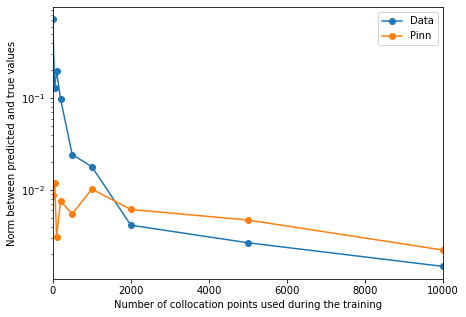

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(n_samples_u,error_data_u,label='Data',marker='o')
ax.plot(n_samples_f,error_data_f,label='Pinn',marker='o')
ax.set_xlabel('Number of collocation points used during the training')
ax.set_ylabel('Norm between predicted and true values')
ax.set_yscale('log')
ax.set_xlim(0,1e4)
plt.legend()